In [1]:
import numpy as np
import sys
import copy
import jax
import jax.numpy as jnp
import importlib
import matplotlib.pyplot as plt
import jaxopt

import anotherpipe.powerestimation.rotatewindow as rw
import anotherpipe.powerestimation.powerestimate as pe
import anotherpipe.powerestimation.covariancematrix as cm
import anotherpipe.utils.math as math

sys.path.append('../bin')
import sculpt_window

In [2]:
import os
plt.style.use(os.path.join(os.path.abspath(''), 'plot_style.mplstyle'))
plots_dir = '../../plots/'

In [3]:
data_type = "secondGenMocksY1"
version = ''

if data_type == "y1":
    data_dir = "/global/cfs/cdirs/desi/users/mpinon/sculpt_window/y1/{}".format(version)
    tracer = "LRG"
    region = "GCcomb"
    kolim = (0., 0.4)
    korebin = 5
    ktrebin = 1
    zmin = 0.4
    zmax = 0.6
    res = ''

if (data_type == "y1") & (version == "test"):
    data_dir = "/global/cfs/cdirs/desi/users/mpinon/sculpt_window/y1/test"
    tracer = "LRG" 
    region = "GCcomb"
    kolim = (0., 0.39)
    korebin = 5
    ktrebin = 1
    zmin = 0.4
    zmax = 0.6
    res = '_nran5_cellsize6_boxsize7000'

if data_type == "secondGenMocksY1":
    data_dir = "/global/cfs/cdirs/desi/users/mpinon/sculpt_window/secondGenMocksY1"
    tracer = "ELG_LOP"
    region = "SGC"
    kolim = (0., 0.4)
    korebin = 1
    ktrebin = 1
    zmin = 0.8
    zmax = 1.6
    res = ''


rpcut = 2.5
ls = [0, 2, 4]
ktmax = 0.5
capsig = 5
difflfac = 10

## Input $P(k)$

In [4]:
#res = sculpt_window.rotate_data(tracer, region, rp_cut=rpcut, ells=ls, kolim=(0., 0.4), korebin=1, ktmax=0.5, ktrebin=1, save_fn=output_fn)

In [5]:
#window_fn = os.path.join(data_dir, "wmatrix_{}_complete_{}{}_ells{}{}_patswmatrix.npy".format(tracer, region, '_rp{:.1f}'.format(rpcut) if rpcut else '', ''.join([str(i) for i in ls]), '' if (highres or data_type == 'y1') else '_lowres'))
window_fn = os.path.join(data_dir, 'wmatrix_smooth_{}_complete_gtlimaging_{}_{:.1f}_{:.1f}_default_lin{}{}_ells{}_analyticcov_ktmax{}_autokwid_capsig{}_difflfac{}.npy'.format(tracer, region, zmin, zmax, res, '_rpcut{:.1f}_directedges'.format(rpcut) if rpcut else '', ''.join([str(i) for i in ls]), ktmax, capsig, difflfac))
from pypower import PowerSpectrumSmoothWindowMatrix
wmnew =  PowerSpectrumSmoothWindowMatrix.load(window_fn)

#power_fn = os.path.join(data_dir, "pkpoles_{}_complete_{}{}_ells{}{}_patswmatrix.npy".format(tracer, region, '_rp{:.1f}'.format(rpcut) if rpcut else '', ''.join([str(i) for i in ls]), '' if (highres or data_type == 'y1') else '_lowres'))
power_fn = os.path.join(data_dir, "pkpoles_{}_complete_gtlimaging_{}_{:.1f}_{:.1f}_default_lin{}{}_ells{}_analyticcov_ktmax{}_autokwid_capsig{}_difflfac{}.npy".format(tracer, region, zmin, zmax, res, '_rpcut{:.1f}'.format(rpcut) if rpcut else '', ''.join([str(i) for i in ls]), ktmax, capsig, difflfac))
pknew = np.load(power_fn)

#cov_fn = os.path.join(data_dir, "cov_{}_complete_{}{}_ells{}{}_patswmatrix.npy".format(tracer, region, '_rp{:.1f}'.format(rpcut) if rpcut else '', ''.join([str(i) for i in ls]), '' if (highres or data_type == 'y1') else '_lowres'))
cov_fn = os.path.join(data_dir, "cov_{}_complete_{}_{:.1f}_{:.1f}{}{}_ells{}_analyticcov_ktmax{}_autokwid_capsig{}_difflfac{}.npy".format(tracer, region, zmin, zmax, res, '_rp{:.1f}'.format(rpcut) if rpcut else '', ''.join([str(i) for i in ls]), ktmax, capsig, difflfac))
covnew = np.load(cov_fn)

In [6]:
from sculpt_window import get_data
data = get_data(data_type, tracer, region, rp_cut=rpcut, zrange=(zmin, zmax), version=version, kolim=kolim, korebin=korebin, ktmax=ktmax, ktrebin=ktrebin)

In [7]:
wm = data['wmatrix']
pk = data['power']
cov = data['covariance']

In [8]:
pk.attrs

{'data_size1': 4531023,
 'sum_data_weights1': 4531023.0,
 'randoms_size1': 102637906,
 'sum_randoms_weights1': 102637906.0,
 'shifted_size1': 0,
 'sum_shifted_weights1': 0.0,
 'resampler1': 'tsc',
 'interlacing1': 2,
 'data_size2': 4531023,
 'randoms_size2': 102637906,
 'shifted_size2': 0,
 'sum_data_weights2': 4531023.0,
 'sum_randoms_weights2': 102637906.0,
 'sum_shifted_weights2': 0.0,
 'resampler2': 'tsc',
 'interlacing2': 2,
 'autocorr': True,
 'nmesh': array([1382, 1382, 1382]),
 'boxsize': array([8292., 8292., 8292.]),
 'boxcenter': array([1803.70141545,  271.19571514,  344.1121525 ]),
 'dtype': dtype('float64'),
 'los': None,
 'los_type': 'firstpoint',
 'compensations': [{'resampler': 'tsc', 'shotnoise': False}, None],
 'corr_direct_D1D2': {'name': 'corrfunc',
  'autocorr': True,
  'is_reversible': True,
  'edges': array([0.00000e+00, 1.00000e-01, 2.00000e-01, ..., 1.43619e+04,
         1.43620e+04, 1.43621e+04]),
  'bin_type': 'lin',
  'ells': (0, 2, 4),
  'sep': array([0.0653

In [9]:
cov.shape

(240, 240)

In [10]:
#data = get_data(data_type, tracer, region, rp_cut=0, zrange=(zmin, zmax), version=version, kolim=kolim, korebin=korebin, ktmax=0.5, ktrebin=ktrebin)
#wm_nocut = data['wmatrix']

In [11]:
wm.shape

(15675, 240)

In [12]:
#ktrebin = 3
#wm = wm.slice_x(slicein=slice(0, len(wm.xin[0]) // ktrebin * ktrebin, ktrebin))

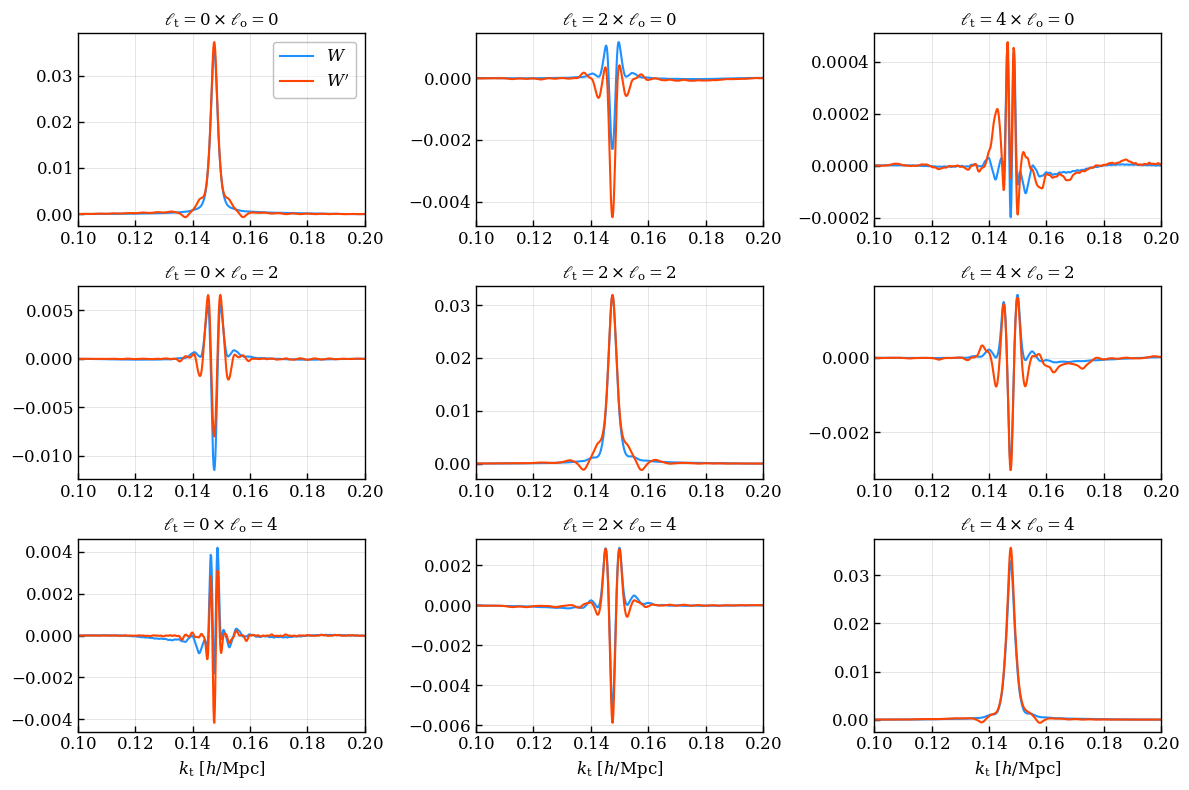

In [13]:
kobs = [0.15]
alphas = [1.]

fig, lax = plt.subplots(len(ls), len(ls), figsize=(12, 8))

for i in range(len(kobs)):
    indexout = np.abs(wm.xout[0] - kobs[i]).argmin()
    
    for iin, projin in enumerate(ls):
        for iout, projout in enumerate(ls):
            ax = lax[iout][iin]
            # Indices in approximative window matrix
            norm = 1. #np.max(np.abs(wm.unpacked()[iin][iout][:, indexout] / wm.xin[iin]))
            ax.plot(wm.xin[iin], wm.unpacked()[iin][iout][:, indexout]/norm, label=r'$W$' if i==len(kobs)-1 else '', color='C0', alpha=alphas[i])
            ax.plot(wmnew.xin[iin], wmnew.unpacked()[iin][iout][:, indexout]/norm, label=r'$W^{\prime}$' if i==len(kobs)-1 else '', color='C1', alpha=alphas[i])
            ax.set_title(r'$\ell_{{\mathrm{{t}}}} = {:d} \times \ell_{{\mathrm{{o}}}} = {:d}$'.format(projin, projout))
            ax.set_xlim((0.1, 0.2))
            if iout == len(ls) - 1: ax.set_xlabel(r'$k_{\mathrm{t}}$ [$h/\mathrm{Mpc}$]')
            if i==len(kobs)-1 and iin == iout == 0: lax[iout][iin].legend()

plt.savefig(os.path.join(plots_dir, '{}{}_sculptedwindow_{}_complete_{}_{}_{}{}_ells{}_autokwid_capsig{}_difflfac{}.png'.format(data_type, '_'+version if data_type == 'y1' else '', tracer, region, zmin, zmax, '_rpcut{}'.format(rpcut) if rpcut else '', ''.join([str(i) for i in ls]), capsig, difflfac)), dpi=300)
plt.show()

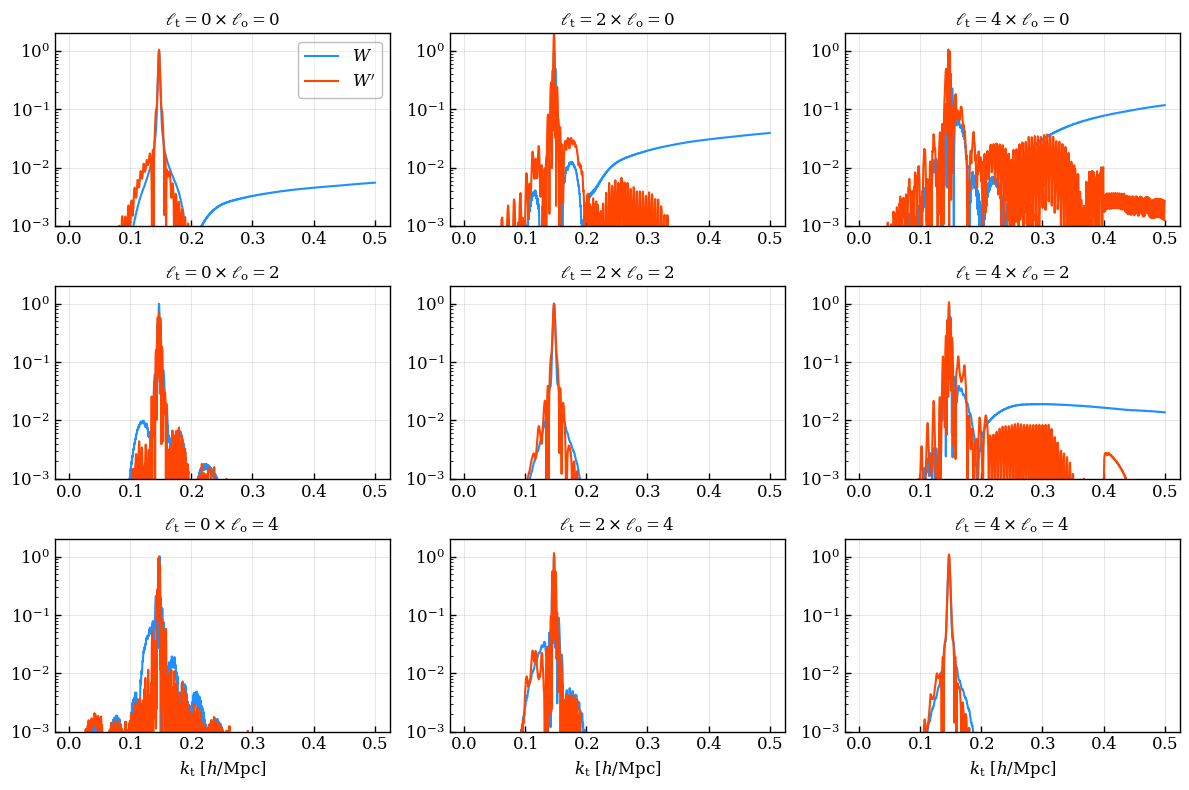

In [14]:
indexout = np.abs(wm.xout[0] - 0.15).argmin()

fig, lax = plt.subplots(len(ls), len(ls), figsize=(12, 8))
for iin, projin in enumerate(ls):
    for iout, projout in enumerate(ls):
        ax = lax[iout][iin]
        # Indices in approximative window matrix
        norm = np.max(np.abs(wm.unpacked()[iin][iout][:, indexout] / wm.xin[iin]))
        ax.semilogy(wm.xin[iin], np.abs(wm.unpacked()[iin][iout][:, indexout]/norm/wm.xin[iin]), label=r'$W$')
        ax.semilogy(wmnew.xin[iin], np.abs(wmnew.unpacked()[iin][iout][:, indexout]/norm/wmnew.xin[iin]), label=r'$W^{\prime}$')
        ax.set_title(r'$\ell_{{\mathrm{{t}}}} = {:d} \times \ell_{{\mathrm{{o}}}} = {:d}$'.format(projin, projout))
        ax.set_ylim((1e-3, 2))
        if iout == len(ls) - 1: ax.set_xlabel(r'$k_{\mathrm{t}}$ [$h/\mathrm{Mpc}$]')
        if iin == iout == 0: lax[iout][iin].legend()

plt.savefig(os.path.join(plots_dir, '{}{}_sculptedwindow_semilogy_{}_complete_{}_{}{}{}_ells{}_autokwid_capsig{}_difflfac{}.png'.format(data_type, '_'+version if data_type == 'y1' else '', tracer, region, zmin, zmax, '_rpcut{}'.format(rpcut) if rpcut else '', ''.join([str(i) for i in ls]), capsig, difflfac)), dpi=300)
plt.show()

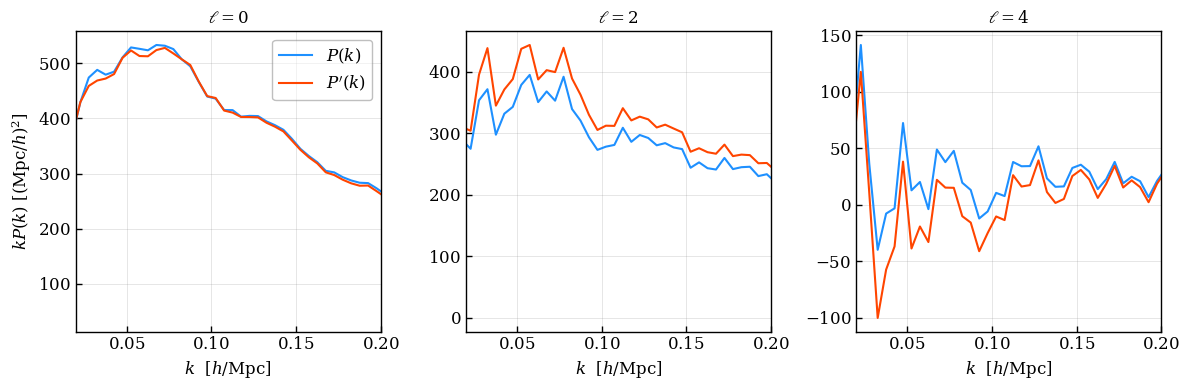

In [15]:
fig, axes = plt.subplots(1, len(ls), figsize=(12, 4), sharey=False)

for i, ell in enumerate(ls):
    axes[i].plot(wm.xout[i], wm.xout[i] * pk(ell=ls, complex=False)[i], color='C0', label=r'$P(k)$')
    axes[i].plot(wmnew.xout[i], wmnew.xout[i] * pknew.reshape((len(ls), len(wmnew.xout[i])))[i], color='C1', label=r'$P^{\prime}(k)$')
    axes[i].set_title(r'$\ell={}$'.format(ell))
    axes[i].set_xlabel(r'$k$  [$h$/Mpc]')
    axes[i].set_xlim((0.02, 0.2))

axes[0].legend()
axes[0].set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.tight_layout(pad=0.3)
plt.savefig(os.path.join(plots_dir, '{}{}_sculptedwindow_transformed_pk_{}_complete_{}{}_ells{}_autokwid_capsig{}_difflfac{}.png'.format(data_type, '_'+version if data_type == 'y1' else '', tracer, region, '_rpcut{}'.format(rpcut) if rpcut else '', ''.join([str(i) for i in ls]), capsig, difflfac)), dpi=300)
plt.show()


In [16]:
data_processed = pe.make(data['power'], data['wmatrix'], data['covariance'])

In [17]:
mask = data_processed.WnormMask(ls=ls)

In [18]:
wmnew.select_proj(projsin=ls, projsout=ls)
wnorm = (wmnew.select_proj(projsin=ls, projsout=ls).value.T*mask).sum(axis=1)

ValueError: Required (Projection(ell=0, wa_order=0), Projection(ell=0, wa_order=0)) is not in matrix. Cannot set diagonal matrix for these projections as expected shape is (5225, 80)

In [ ]:
wmnewnorm = wmnew.deepcopy().select_proj(projsin=ls, projsout=ls)
wmnewnorm.value = wmnewnorm.value / wnorm[:, None].T
pknewnorm = pknew / wnorm
covnewnorm = covnew / wnorm[:, None] / wnorm[None, :]

In [ ]:
fig, axes = plt.subplots(1, len(ls), figsize=(12, 4), sharey=True)

for i, ell in enumerate(ls):
    axes[i].plot(wm.xout[i], wm.xout[i] * pk(ell=ls, complex=False)[i], color='C0', label=r'$P(k)$')
    axes[i].plot(wm.xout[i], wm.xout[i] * pknew.reshape((len(ls), len(wm.xout[i])))[i], color='C1', label=r'$P^{\prime}(k)$')
    axes[i].plot(wm.xout[i], wm.xout[i] * pknewnorm.reshape((len(ls), len(wm.xout[i])))[i], color='C1', label=r'normed $P^{\prime}(k)$', ls='--')
    axes[i].set_title(r'$\ell={}$'.format(ell))
    axes[i].set_xlabel(r'$k$  [$h$/Mpc]')

axes[0].legend()
axes[0].set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.tight_layout(pad=0.3)
plt.savefig(os.path.join(plots_dir, '{}_sculptedwindow_transformed_pknormed_{}_complete_{}_{}{}{}_ells{}.png'.format(data_type, tracer, region, zmin, zmax, '_rpcut{}'.format(rpcut) if rpcut else '', ''.join([str(i) for i in ls]))), dpi=300)
plt.show()